In [1]:
from csromer.simulation import FaradayThinSource,FaradayThickSource
from csromer.reconstruction import Parameter
import numpy as np
from IPython.display import clear_output
from csromer.io import Reader, Writer, filter_cubes
from csromer.base import Dataset
from csromer.transformers import DFT1D, NUFFT1D
import matplotlib.pyplot as plt
from csromer.objectivefunction import OFunction
from csromer.utils import real_to_complex, complex_to_real
from csromer.objectivefunction import TSV, TV, L1, Chi2
from csromer.optimization import FISTA, ADMM, SDMM, GradientBasedMethod
from csromer.utils import Gaussian
from csromer.dictionaries.discrete import DiscreteWavelet
from csromer.dictionaries.undecimated import UndecimatedWavelet
from csromer.transformers import Gridding, ManualFlagger, MeanFlagger, HampelFlagger
from csromer.faraday_sky import FaradaySky
from scipy.constants import c
from pynufft import NUFFT
from scipy import signal as sci_signal
import itertools
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as un
from astropy.stats import sigma_clipped_stats
from scipy.stats import median_abs_deviation
from regions import Regions
from regions import PixCoord

In [2]:
def get_image_coordinates(header, w):
    m = header["NAXIS1"]
    n = header["NAXIS2"]
    try:
        frame = header["RADESYS"].lower()
    except KeyError:
        frame="fk5"
    x = np.arange(0, m, 1)
    y = np.arange(0, n, 1)
    xx, yy = np.meshgrid(x, y)

    ra, dec = w.all_pix2world(xx, yy, 0) * un.deg
    sky_coord = SkyCoord(ra=ra, dec=dec, frame=frame)
    
    return sky_coord

In [3]:
# Read cubes
reader = Reader()
IQUV_name = "/home/miguel/Documents/datasets/A1314_JVLA/cubes/cubes.fits"
IQUV_header, IQUV = reader.readCube(file=IQUV_name)

FITS shape:  (4, 1024, 1024, 1024)


In [4]:
I, Q, U, nu = filter_cubes(IQUV[0], IQUV[1], IQUV[2], IQUV_header, 286)

Filtering 33.79% of the total data


In [5]:
# Read spectral index
spc_idx_name = "/home/miguel/Documents/datasets/A1314_JVLA/mfs/alpha.fits"
hdul_alpha = fits.open(spc_idx_name, memmap=True)

In [6]:
# Get LOS
title = "IC712 "
#coord = SkyCoord(ra=173.498*un.deg, dec=49.063*un.deg, frame="fk5") # IC708
coord = SkyCoord(ra=173.705*un.deg, dec=49.078*un.deg, frame="fk5") # IC712
#coord = SkyCoord(ra=173.694*un.deg, dec=48.957*un.deg, frame="fk5") # IC711
#coord = SkyCoord(ra=173.675*un.deg, dec=48.973*un.deg, frame="fk5") # IC711 tail peak
#coord = SkyCoord(ra=173.470*un.deg, dec=49.075*un.deg, frame="fk5") # IC708 North Lobe peak
#coord = SkyCoord(ra=173.470*un.deg, dec=49.057*un.deg, frame="fk5") # IC708 South Lobe peak
#coord = SkyCoord(ra=173.803*un.deg, dec=48.967*un.deg, frame="fk5")# Source 13
#coord = SkyCoord(ra=173.453*un.deg, dec=48.985*un.deg, frame="fk5")# Source 1

In [7]:
# Get WCS
wcs = WCS(IQUV_header, naxis=2)

Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [8]:
coords = get_image_coordinates(IQUV_header, wcs)

In [9]:
# Get pixel
x,y = coord.to_pixel(wcs, origin=0)
x = int(x)
y = int(y)
# x = noise_idxs[0][1]
# y = noise_idxs[1][1]

In [10]:
q_data = np.flipud(Q)
u_data = np.flipud(U)

In [11]:
# Get sigma
mean_q, median_q, std_q = sigma_clipped_stats(q_data[:, 0:300, 0:300], sigma=5, axis=(1,2))
mean_u, median_u, std_u = sigma_clipped_stats(u_data[:, 0:300, 0:300], sigma=5, axis=(1,2))
#std_q = np.nanstd(q_data[:, 0:500, 0:500], axis=(1, 2))
#std_u = np.nanstd(u_data[:, 0:500, 0:500], axis=(1, 2))

In [12]:
mean_qu = 0.5 * (mean_q + mean_u)
sigma_qu = 0.5 * (std_q + std_u)

In [13]:
data = q_data[:,y,x] + 1.0j * u_data[:,y,x]
alpha = hdul_alpha[0].data[y,x]

In [14]:
alpha

-0.7176478

In [15]:
measurements = Dataset(nu=nu, data=data, sigma=sigma_qu, spectral_idx=alpha)

In [16]:
# Get galactic RM contribution
f_sky = FaradaySky()
gal_mean, gal_std = f_sky.galactic_rm(coord.ra, coord.dec, frame="fk5")

In [17]:
measurements.subtract_galacticrm(gal_mean.value)

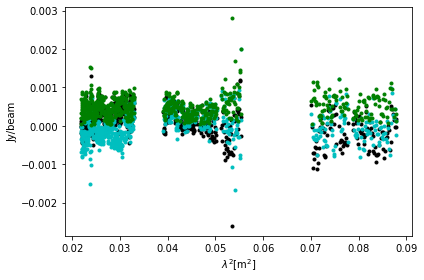

In [18]:
plt.plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [19]:
mean_sigma = np.mean(measurements.sigma)
stderr_sigma = np.std(measurements.sigma) / np.sqrt(len(measurements.sigma))
print(mean_sigma)
print(stderr_sigma)
print(mean_sigma + 5*stderr_sigma)

0.0005069893118216346
8.235030917362191e-06
0.0005481644664084456


Text(0, 0.5, '1/(Jy/beam)$^2$')

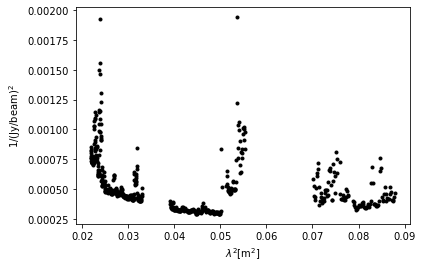

In [20]:
plt.plot(measurements.lambda2, measurements.sigma, 'k.', label=r"$\sigma$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'1/(Jy/beam)$^2$')

In [21]:
## Flagging dataset ##
normal_flagger = MeanFlagger(data=measurements, nsigma=5.0, delete_channels=True)
idxs, outliers_idxs = normal_flagger.run()
#hampel_flagger = HampelFlagger(data=measurements, nsigma=5.0, delete_channels=True)
#idxs, outliers_idxs = hampel_flagger.run()

Flagging 26.40% of the data


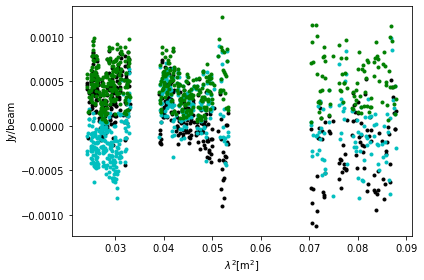

In [22]:
plt.plot(measurements.lambda2, measurements.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [23]:
uni_theo_noise = np.mean(measurements.sigma)/np.sqrt(2*measurements.m)
theo_noise = measurements.theo_noise
print(measurements.theo_noise*1000.0)
print(theo_noise*1000.0)
#measurements.sigma = theo_noise * np.ones_like(measurements.sigma)

0.017264267625562907
0.017264267625562907


Text(0, 0.5, 'Jy/beam')

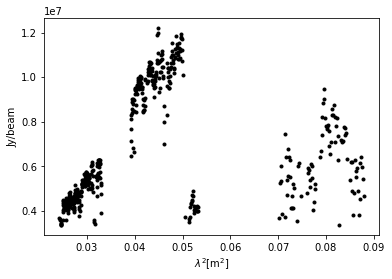

In [24]:
plt.plot(measurements.lambda2, measurements.w, 'k.', label=r"$\sigma$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')

Text(0, 0.5, 'Spectral index')

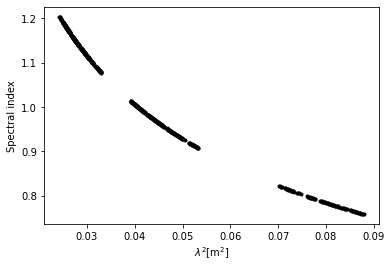

In [25]:
plt.plot(measurements.lambda2, measurements.s, 'k.', label=r"$\sigma$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Spectral index')

In [26]:
parameter = Parameter()

In [27]:
parameter.calculate_cellsize(dataset=measurements, oversampling=8)

FWHM of the main peak of the RMTF: 54.380 rad/m^2
Maximum recovered width structure: 129.664 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 13540.615


In [28]:
nufft = NUFFT1D(dataset=measurements, parameter=parameter, solve=True)

In [29]:
dft = DFT1D(dataset=measurements, parameter=parameter)

In [30]:
F_dirty = dft.backward(measurements.data)

In [31]:
rmtf = dft.RMTF(measurements.data)

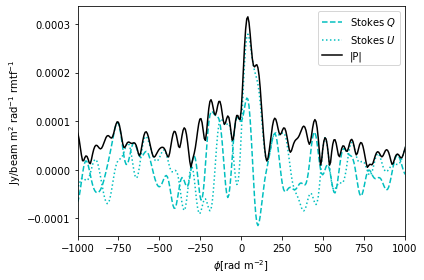

In [32]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), 'k-', label=r"|P|")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
#plt.savefig('fdirty.png', dpi=100, bbox_inches='tight')

In [33]:
SMALL_SIZE = 17
MEDIUM_SIZE = 18
BIGGER_SIZE = 19

plt.rcParams.update({
                "font.family": "serif",
                "text.usetex": True,
                "pgf.rcfonts": False,
                "pgf.texsystem": 'pdflatex',  # default is xetex
            })

plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize

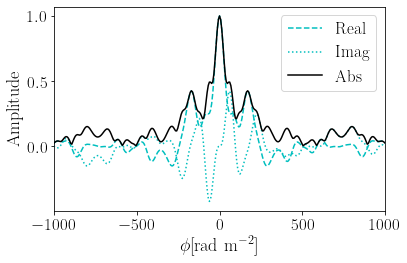

In [34]:
plt.plot(parameter.phi, rmtf.real, 'c--', label=r"Real")
plt.plot(parameter.phi, rmtf.imag, 'c:', label=r"Imag")
plt.plot(parameter.phi, np.abs(rmtf), 'k-', label=r"Abs")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Amplitude')
plt.legend(loc='upper right')
plt.xlim([-1000,1000])
plt.tight_layout()
plt.savefig('rmtf.pdf', dpi=100, bbox_inches='tight')

In [35]:
parameter.phi[np.argmax(np.abs(F_dirty))]

40.949441509856314

In [36]:
noise_std_full = 0.5 * (np.nanstd(F_dirty.real) + np.nanstd(F_dirty.imag))
noise_std_full * 1000.0

0.022034873836673796

In [37]:
noise_idx = np.where(np.abs(parameter.phi)>parameter.max_faraday_depth*0.8)
noise_std = 0.5 * (np.std(F_dirty.real[noise_idx]) + np.std(F_dirty.imag[noise_idx]))
noise_std * 1000.0

0.011324813385726884

In [38]:
noise_mad = 0.5*(median_abs_deviation(F_dirty[noise_idx].real, scale="normal") + median_abs_deviation(F_dirty[noise_idx].imag, scale="normal"))
noise_mad * 1000.0

0.011497964607171776

In [39]:
theo_noise * 1000.0

0.017264267625562907

In [40]:
#wav = None
wav = DiscreteWavelet(wavelet_name="db4", mode="periodization", append_signal=True)
#wav = UndecimatedWavelet(wavelet_name="coif2", mode="periodization", append_signal=False)

In [41]:
lambda_l1 = np.sqrt(measurements.m + 2*np.sqrt(measurements.m)) * 2. * theo_noise
#lambda_l1 = np.sqrt(len(measurements.data)) * noise_F
#lambda_l1 /= 4
#lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft, wavelet=wav)
l1 = L1(reg=lambda_l1)
#tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1]
f_func = [chi2]
g_func = [l1]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [42]:
lambda_l1

0.0008050975078360524

In [43]:
parameter.data = F_dirty
parameter.complex_data_to_real()
if wav is not None:
    wav.calculate_max_level(parameter.data)
    parameter.data = wav.decompose(parameter.data)

In [44]:
parameter.n

15873

In [45]:
nufft.parameter.n

3968

In [46]:
opt = FISTA(guess_param=parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=2.*theo_noise, verbose=True)
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()

Iterations set to 23
Iteration:  0  objective function value: 413.35544
Iteration:  10  objective function value: 413.35544
Iteration:  20  objective function value: 311.03346


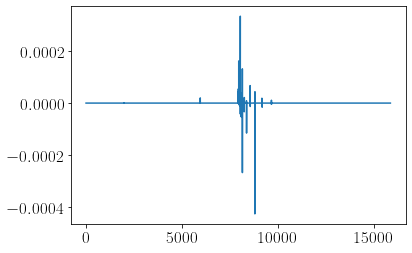

In [47]:
if wav is not None:
    plt.plot(X.data)

In [48]:
if wav is not None:
    X.data = wav.reconstruct(X.data)
X.real_data_to_complex()

(-1000.0, 1000.0)

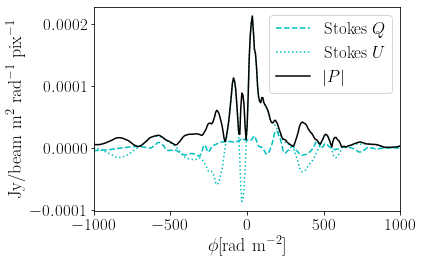

In [49]:
plt.plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000,1000])

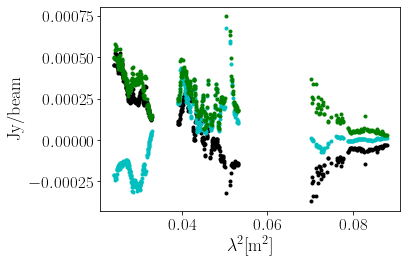

In [50]:
plt.plot(measurements.lambda2, measurements.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, measurements.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(measurements.model_data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

In [51]:
fitted = measurements.w * measurements.model_data / measurements.s

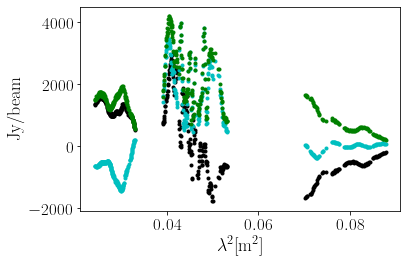

In [52]:
plt.plot(measurements.lambda2, fitted.real, 'k.', label=r"Stokes $Q$")
plt.plot(measurements.lambda2, fitted.imag, 'c.', label=r"Stokes $U$")
plt.plot(measurements.lambda2, np.abs(fitted), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
#plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('polarized.png', dpi=100, bbox_inches='tight')

(-1000.0, 1000.0)

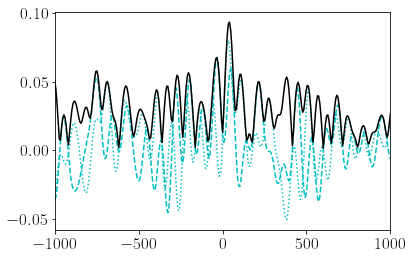

In [53]:
F_residual = dft.backward(measurements.residual)
plt.plot(parameter.phi, F_residual.real*1000.0, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_residual.imag*1000.0, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_residual)*1000.0, 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])

In [54]:
conv_model = X.convolve(normalized=True) + F_residual

In [55]:
noise_residual = 0.5*(np.std(F_residual.real) + np.std(F_residual.imag))
noise_residual * 1000.0

0.014319753972813487

In [56]:
noise = 0.5*(np.std(F_dirty.real[np.abs(parameter.phi)>parameter.max_faraday_depth*0.8]) + np.std(F_dirty.imag[np.abs(parameter.phi)>parameter.max_faraday_depth*0.8]))
noise * 1000.0

0.011324813385726884

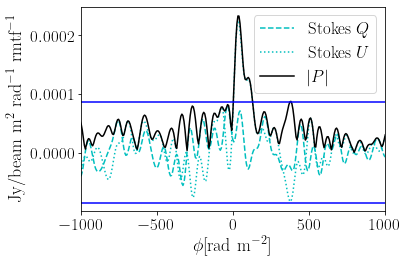

In [57]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
plt.xlim([-1000,1000])
plt.axhline (y = 5*theo_noise, color = 'b')
plt.axhline (y = -5*theo_noise, color = 'b')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()

In [58]:
phi_idx = np.argmax(np.abs(conv_model))
parameter.phi[phi_idx]

34.12453459154693

In [59]:
np.argmax(conv_model.real), np.argmax(conv_model.imag)

(1979, 1989)

In [60]:
np.max(np.abs(conv_model))

0.00023317587551396457

In [61]:
noise * 1000.0

0.011324813385726884

In [62]:
noise/np.max(np.abs(conv_model))

0.04856768892049751

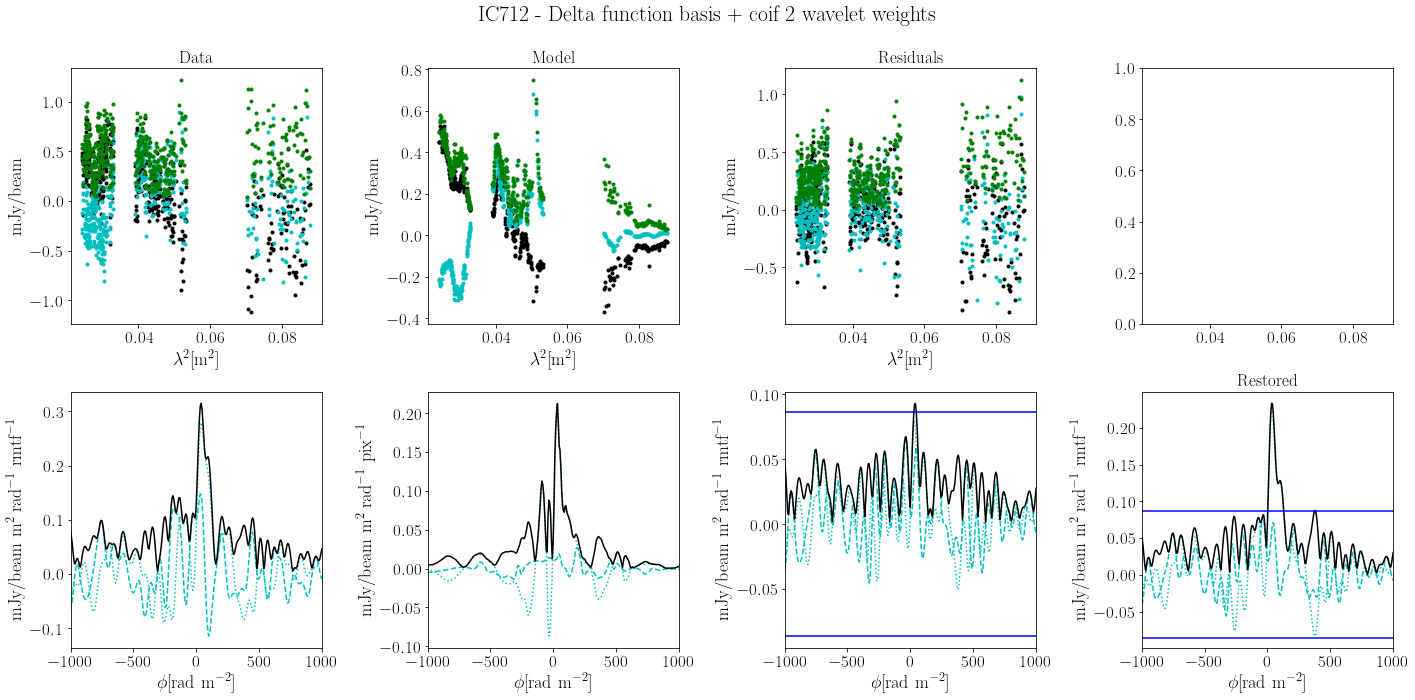

In [63]:
fig, ax = plt.subplots(nrows=2, ncols=4, sharex='row', figsize=(20, 10))

# Data
ax[0,0].plot(measurements.lambda2, measurements.data.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[0,0].plot(measurements.lambda2, measurements.data.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[0,0].plot(measurements.lambda2, np.abs(measurements.data) * 1000.0, 'g.', label=r"$|P|$")
ax[0,0].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0,0].set_ylabel(r'mJy/beam')
ax[0,0].title.set_text("Data")

ax[1,0].plot(parameter.phi, F_dirty.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1,0].plot(parameter.phi, F_dirty.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1,0].plot(parameter.phi, np.abs(F_dirty) * 1000.0, 'k-', label=r"|P|")
ax[1,0].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,0].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1,0].set_xlim([-1000,1000])

# Model
ax[0,1].plot(measurements.lambda2, measurements.model_data.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[0,1].plot(measurements.lambda2, measurements.model_data.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[0,1].plot(measurements.lambda2, np.abs(measurements.model_data) * 1000.0, 'g.', label=r"$|P|$")
ax[0,1].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0,1].set_ylabel(r'mJy/beam')
ax[0,1].title.set_text("Model")
# Model
ax[1,1].plot(parameter.phi, X.data.real * 1000.0, 'c--', label=r"Stokes $Q$")
ax[1,1].plot(parameter.phi, X.data.imag * 1000.0, 'c:', label=r"Stokes $U$")
ax[1,1].plot(parameter.phi, np.abs(X.data) * 1000.0, 'k-', label=r"$|P|$")
ax[1,1].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,1].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
ax[1,1].set_xlim([-1000,1000])

# Residual


ax[0,2].plot(measurements.lambda2, measurements.residual.real * 1000.0, 'k.', label=r"Stokes $Q$")
ax[0,2].plot(measurements.lambda2, measurements.residual.imag * 1000.0, 'c.', label=r"Stokes $U$")
ax[0,2].plot(measurements.lambda2, np.abs(measurements.residual) * 1000.0, 'g.', label=r"$|P|$")
ax[0,2].set_xlabel(r'$\lambda^2$[m$^{2}$]')
ax[0,2].set_ylabel(r'mJy/beam')
ax[0,2].title.set_text("Residuals")

ax[1,2].plot(parameter.phi, F_residual.real* 1000.0, 'c--', label=r"Stokes $Q$")
ax[1,2].plot(parameter.phi, F_residual.imag* 1000.0, 'c:', label=r"Stokes $U$")
ax[1,2].plot(parameter.phi, np.abs(F_residual)* 1000.0, 'k-', label=r"$|P|$")
ax[1,2].axhline (y = 5*theo_noise*1000.0, color = 'b')
ax[1,2].axhline (y = -5*theo_noise*1000.0, color = 'b')
ax[1,2].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,2].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1,2].set_xlim([-1000,1000])


ax[1,3].plot(parameter.phi, conv_model.real* 1000.0, 'c--', label=r"Stokes $Q$")
ax[1,3].plot(parameter.phi, conv_model.imag* 1000.0, 'c:', label=r"Stokes $U$")
ax[1,3].plot(parameter.phi, np.abs(conv_model)* 1000.0, 'k-', label=r"$|P|$")
ax[1,3].axhline (y = 5*theo_noise*1000.0, color = 'b')
ax[1,3].axhline (y = -5*theo_noise*1000.0, color = 'b')
ax[1,3].set_xlim([-1000,1000])
ax[1,3].set_xlabel(r'$\phi$[rad m$^{-2}$]')
ax[1,3].set_ylabel(r'mJy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
ax[1,3].title.set_text("Restored")


if wav is None:
    title += "- Delta function basis "
else:
    if wav.append_signal is True:
        title += "- Delta function basis + coif 2 wavelet "
    else:
        title += "- {0} wavelet ".format(wav.wavelet_name)

if (measurements.w == measurements.w[0]).all():
    title += "uniform weights equal to {0:.3f}".format(measurements.w[0])   
else:
    title += "weights "



fig.suptitle(title)
fig.tight_layout()

In [64]:
noise * 1000.0

0.011324813385726884

In [65]:
theo_noise*1000.0

0.017264267625562907

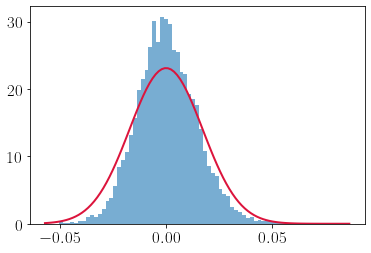

In [66]:
from scipy.stats import norm
residual_all = np.concatenate([F_residual.real, F_residual.imag])*1000.0
mu, std = norm.fit(residual_all)
_, bins, _ = plt.hist(residual_all, density=True, alpha=0.6, bins='auto')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0.0, theo_noise*1000.0)
plt.plot(x, p, 'crimson', linewidth=2)